# Import Packages

In [15]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import pytz 
import re
import nltk
from nltk.corpus import stopwords
import ast
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
nltk.corpus.stopwords.words('indonesian')
from nltk.tokenize import TweetTokenizer
import preprocessor as p

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\prime\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prime\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Word Processing

## Import Lexicon data

import lexicon, and remove negation words from lexicon, the lexicon is a combination from several sources below, that combined together, and include swear words which has the most negative score

sources : <br>
https://github.com/louisowen6/NLP_bahasa_resources <br>
https://github.com/abhimantramb/elang/blob/master/word2vec/utils/swear-words.txt <br>
https://github.com/fajri91/InSet <br>
https://github.com/agusmakmun/SentiStrengthID/blob/master/id_dict/sentimentword.txt 

In [16]:
lexicon = pd.read_csv("lexicon/modified_full_lexicon.csv")
lexicon_word = lexicon['word'].to_list()
lexicon_num_words = lexicon['number_of_words']
lexicon.head()

,word,weight,number_of_words
0,hai,3,1
1,merekam,2,1
2,ekstensif,3,1
3,paripurna,1,1
4,detail,2,1


# Import Data

In [17]:
df = pd.read_excel('raw_sentiment.xlsx')
df = df.drop_duplicates()
df = df.dropna(subset=['content'])
df = df.reset_index(drop=True)
df.head()

,Unnamed: 0,content
0,0,Semoga g omicron ya Tuhan
1,1,"@dinagustavsson Ada delta,omicron ,cacar munyu..."
2,2,Ayo sukseskan vaksinasi Covid-19 dengan melaku...
3,3,Agar terhindar dr varian baru omicron BA.4 &am...
4,4,"Ambil baik nya, pas kenapa omicron, pertama bi..."


In [18]:
len(df)

1000

# Preprocessing

In [19]:
df['hashtag'] = df['content'].apply(lambda x: re.findall(r"#(\w+)", x))

for i,v in enumerate(df['content']):
    df.loc[i,'content'] = p.clean(v)

def preprocess_data(data):
    #Removes Numbers
    data = data.astype(str).str.replace('\d+', '')
    lower_text = data.str.lower()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    w_tokenizer =  TweetTokenizer()
 
    def lemmatize_text(text):
        return [(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize((text))]
    
    def remove_punctuation(words):
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', (word))
            if new_word != '':
                new_words.append(new_word)
        return new_words
 
    words = lower_text.apply(lemmatize_text)
    words = words.apply(remove_punctuation)
    return pd.DataFrame(words)

pre_tweets = preprocess_data(df['content'])
df['content'] = pre_tweets
stop_words = set(stopwords.words('indonesian'))
df['content'] = df['content'].apply(lambda x: [item for item in x if item not in stop_words])
df['content'] = df['content'].str.join(" ")
from ekphrasis.classes.segmenter import Segmenter
# segmenter using the word statistics from Twitter
seg_tw = Segmenter(corpus="twitter")
a = []
for i in range(len(df)):
    if any(h in df['hashtag'][i] for h in a):
        listToStr1 = ' '.join([str(elem) for elem in df['hashtag'][i]])
        df.loc[i,'Segmented#'] = seg_tw.segment(listToStr1)

C:\Users\prime\AppData\Local\Temp/ipykernel_16844/3538242542.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  data = data.astype(str).str.replace('\d+', '')


Reading twitter - 1grams ...
Reading twitter - 2grams ...


C:\Users\prime\miniconda3\lib\site-packages\ekphrasis\classes\exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [20]:
negasi = ["tidak", "enggak", "nggak", "gak", "gk", "ga", "g", "tdk", "tak"]
sencol =[]
senrow =np.array([])
nsen = 0
factory = StemmerFactory()
stemmer = factory.create_stemmer()
sentiment_list = []
# function to write the word's sentiment if it is founded
def found_word(ind,words,word,sen,sencol,sentiment,add):
    # if it is already included in the bag of words matrix, then just increase the value
    if word in sencol:
        sen[sencol.index(word)] += 1
    else:
    #if not, than add new word
        sencol.append(word)
        sen.append(1)
        add += 1
    #if there is a negation word before it, the sentiment would be the negation of it's sentiment
    if (words[ind-1] in negasi):
        sentiment += -lexicon['weight'][lexicon_word.index(word)]
    else:
        sentiment += lexicon['weight'][lexicon_word.index(word)]
    
    return sen,sencol,sentiment,add
            
# checking every words, if they are appear in the lexicon, and then calculate their sentiment if they do
for i in range(len(df)):
    nsen = senrow.shape[0]
    words = word_tokenize(df['content'][i])
    sentiment = 0 
    add = 0
    prev = [0 for ii in range(len(words))]
    n_words = len(words)
    if len(sencol)>0:
        sen =[0 for j in range(len(sencol))]
    else:
        sen =[]
    
    for word in words:
        ind = words.index(word)
        # check whether they are included in the lexicon
        if word in lexicon_word :
            sen,sencol,sentiment,add= found_word(ind,words,word,sen,sencol,sentiment,add)
        else:
        # if not, then check the root word
            kata_dasar = stemmer.stem(word)
            if kata_dasar in lexicon_word:
                sen,sencol,sentiment,add= found_word(ind,words,kata_dasar,sen,sencol,sentiment,add)
        # if still negative, try to match the combination of words with the adjacent words
            elif(n_words>1):
                if ind-1>-1:
                    back_1    = words[ind-1]+' '+word
                    if (back_1 in lexicon_word):
                        sen,sencol,sentiment,add= found_word(ind,words,back_1,sen,sencol,sentiment,add)
                    elif(ind-2>-1):
                        back_2    = words[ind-2]+' '+back_1
                        if back_2 in lexicon_word:
                            sen,sencol,sentiment,add= found_word(ind,words,back_2,sen,sencol,sentiment,add)
    # if there is new word founded, then expand the matrix
    if add>0:  
        if i>0:
            if (nsen==0):
                senrow = np.zeros([i,add],dtype=int)
            elif(i!=nsen):
                padding_h = np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding_h))
                padding_v = np.zeros([(i-nsen),senrow.shape[1]],dtype=int)
                senrow = np.vstack((senrow,padding_v))
            else:
                padding =np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding))
            senrow = np.vstack((senrow,sen))
        if i==0:
            senrow = np.array(sen).reshape(1,len(sen))
    # if there isn't then just update the old matrix
    elif(nsen>0):
        senrow = np.vstack((senrow,sen))
        
    sentiment_list.append(sentiment)

In [33]:
sencol.append('sentiment')
sentiment_array = np.array(sentiment_list).reshape(senrow.shape[0],1)
sentiment_data = np.hstack((senrow,sentiment_array))
df_sen = pd.DataFrame(sentiment_data,columns = sencol)
cek_df = pd.DataFrame([])
cek_df['text'] = df['content'].copy()
cek_df['sentiment']  = df_sen['sentiment'].copy()
cek_df.to_excel('omicron_sentiment.xlsx')
cek_df.head()

ValueError: Shape of passed values is (1000, 978), indices imply (1000, 979)

In [34]:
data = pd.read_excel("omicron_sentiment.xlsx")
data.dropna()
data.reset_index()
data.head()

,Unnamed: 0,text,sentiment
0,0,semoga g omicron ya tuhan,8
1,1,delta omicron cacar munyuk sampe hiv akibat va...,1
2,2,ayo sukseskan vaksinasi covid vaksin dosis len...,2
3,3,terhindar dr varian omicron ba ba masyarakat d...,-3
4,4,ambil nya pa omicron account tik tok haha tik ...,-5


In [35]:
pengobatan = ["pengobatan", "ampuh", "praktis", "murah", "vaksin", "efek", "samping", "sakit", "sembuh", "booster", "vitamin"]
pemerintah = ["layanan", "pemerintah", "bagus", "gampang", "efektif", "lockdown", "wisma", "rumah", "sakit", "swab", "rapid", "ppkm"]

pengobatan_=[]
pemerintah_ = []

for i in range(len(data['text'])):
    if any(e_pengobatan in data['text'][i] for e_pengobatan in pengobatan):
        if data['sentiment'][i] < 0:
            pengobatan_.append(-1)
        elif data['sentiment'][i] > 0:
            pengobatan_.append(1)
        else:
            pengobatan_.append(0)
    else:
        pengobatan_.append(0)

    if any(e_pemerintah in data['text'][i] for e_pemerintah in pemerintah):
        if data['sentiment'][i] < 0:
            pemerintah_.append(-1)
        elif data['sentiment'][i] > 0:
            pemerintah_.append(1)
        else:
            pemerintah_.append(0)
    else:
        pemerintah_.append(0)

if "pengobatan" in data.columns:
    data = data.drop(columns=["pengobatan"])
data.insert(0, "pengobatan", pengobatan_)
if "pemerintah" in data.columns:
    data = data.drop(columns=["pemerintah"])
data.insert(0, "pemerintah", pemerintah_)
data = data.dropna()


data.head()

,pemerintah,pengobatan,Unnamed: 0,text,sentiment
0,0,0,0,semoga g omicron ya tuhan,8
1,0,0,1,delta omicron cacar munyuk sampe hiv akibat va...,1
2,0,1,2,ayo sukseskan vaksinasi covid vaksin dosis len...,2
3,0,-1,3,terhindar dr varian omicron ba ba masyarakat d...,-3
4,0,0,4,ambil nya pa omicron account tik tok haha tik ...,-5


In [36]:
data.to_excel("after_labelling.xlsx")

In [54]:
data = pd.read_excel("after_labelling.xlsx")

In [55]:
df = data

# Word Cloud

In [56]:
word_to_plot_pemerintah_negatif = df[df['pemerintah'] == -1]['text'].copy()
word_to_plot_pemerintah_positif = df[df['pemerintah'] == 1]['text'].copy()
word_to_plot_pengobatan_negatif = df[df['pengobatan'] == -1]['text'].copy()
word_to_plot_pengobatan_positif = df[df['pengobatan'] == 1]['text'].copy()

creating word cloud to see what kind of words that appear often in the tweets related to the pandemic

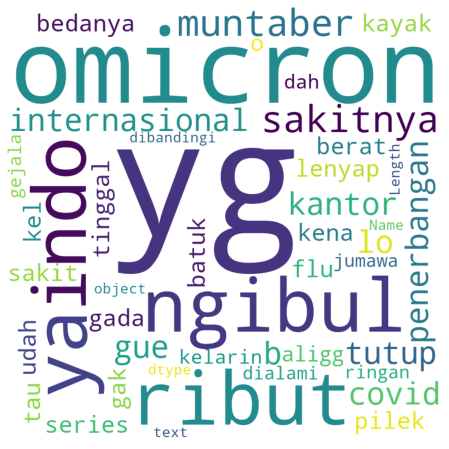

In [57]:
wordcloud = WordCloud(width = 800, height = 800, background_color = 'white'
                      , min_font_size = 20).generate(str(word_to_plot_pemerintah_negatif))

#plot the word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('pemerintah_negatif.png')
plt.show()


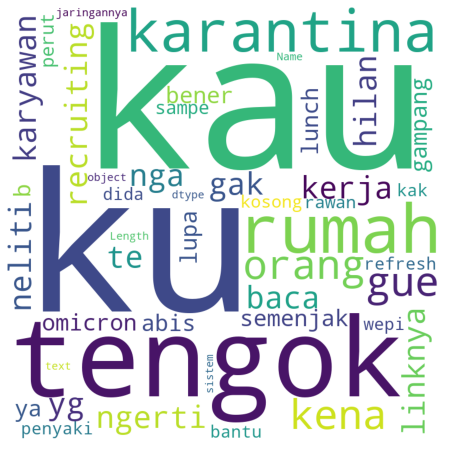

In [58]:
wordcloud = WordCloud(width = 800, height = 800, background_color = 'white'
                      , min_font_size = 20).generate(str(word_to_plot_pemerintah_positif))

#plot the word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('pemerintah_positif.png')
plt.show()


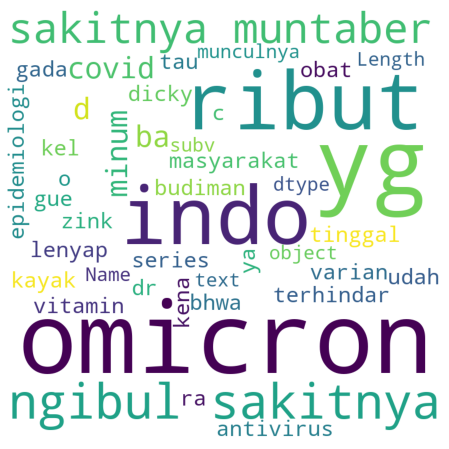

In [59]:
wordcloud = WordCloud(width = 800, height = 800, background_color = 'white'
                      , min_font_size = 20).generate(str(word_to_plot_pengobatan_negatif))

#plot the word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('pengobatan_negatif.png')
plt.show()


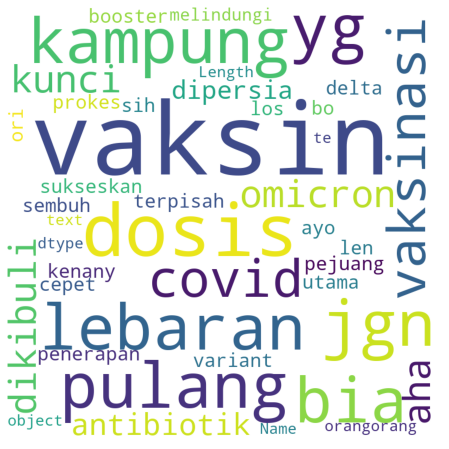

In [60]:
wordcloud = WordCloud(width = 800, height = 800, background_color = 'white'
                      , min_font_size = 20).generate(str(word_to_plot_pengobatan_positif))

#plot the word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('pengobatan_positif.png')
plt.show()


# EDA

Text(0.5, 0, 'sentiment')

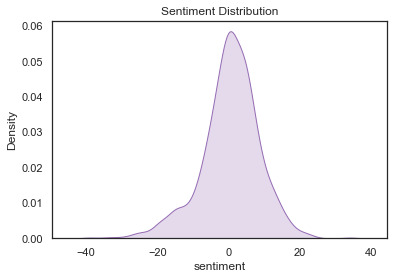

In [62]:
sns.set(style="white", palette="muted", color_codes=True)
sns.kdeplot(df_sen['sentiment'],color='m',shade=True)
plt.title('Sentiment Distribution')
plt.xlabel('sentiment')

<AxesSubplot:xlabel='sentiment'>

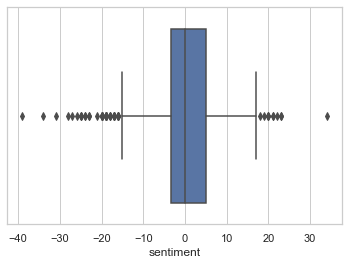

In [63]:
sns.set(style="whitegrid") 
sns.boxplot(x=df_sen['sentiment'])

It look like the sentiments are equally distributed between positive and negative, to be sure, lets take a look at the mean

In [64]:
df_sen.describe()

,moga,ya,tuhan,akibat,beruntung,bebas,ayo,sukses,lengkap,terhindar,...,bilik,special,sorangan,dua,sharing,melekat,goreng,ngaku,instansi,sentiment
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.016000,0.096000,0.003000,0.022000,0.001000,0.004000,0.028000,0.003000,0.014000,0.005000,...,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.002000,0.002000,0.001000,0.393000
std,0.125538,0.326942,0.054717,0.153426,0.031623,0.063151,0.193011,0.054717,0.117549,0.070569,...,0.031623,0.031623,0.031623,0.031623,0.031623,0.031623,0.063246,0.063246,0.031623,8.184714
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-39.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.250000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
max,1.000000,3.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,34.000000


now lets take a look at the most occured words among the set of words that is included in lexicon

In [65]:
top15_word = df_sen.drop(['sentiment'],axis=1).sum().sort_values(ascending=False)[0:15]

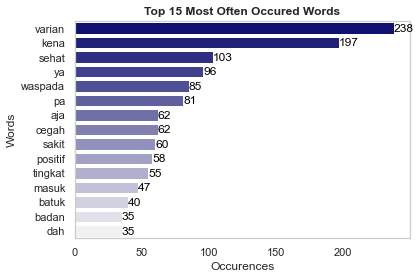

In [66]:
#pal =sns.dark_palette("purple", input="xkcd",n_colors=15)
pal =sns.light_palette("navy", reverse=True,n_colors=15)
g = sns.barplot(y = top15_word.index , x = top15_word,palette=pal)
g.grid(False)
plt.xlabel('Occurences')
plt.ylabel('Words')
plt.title("Top 15 Most Often Occured Words",fontweight='bold') 
for i in range(15):
    g.text(top15_word[i],i+0.22, top15_word[i],color='black')
plt.show()